In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
from PIL import Image
from matplotlib.ticker import FuncFormatter


In [5]:
def plot_liq(df_day, hour, ax, show = True):
    df_day = df_day[df_day['hour'] == hour].sort_values(by='priceMid')
    x = df_day['priceMid'].values
    w = np.diff(x).min() * 0.8 
    
    ax.bar(x, df_day['usd_token0'], width =w, label = 'USDC', color = "cornflowerblue")
    ax.bar(x, df_day['usd_token1'], width =w, label = 'USDT', color = "mediumaquamarine")
    ax.axvline(1, color = 'black')
    ax.axvline(df_day.query('usd_token0 > 0')['priceMid'].values[0], color = 'grey', linestyle = '--', label = 'active tick')
    # plt.bar(x, df_day['usd_total'], width =w)
    ax.set_xlabel('USDC price')
    ax.set_ylabel('tick liquiditiy ($)')
    ax.legend(frameon = False, bbox_to_anchor= (0.62,-0.1), ncols = 3)

In [6]:
df = pd.read_parquet('./hourly_liquidity_full.parquet')
dfp = pd.read_parquet('./hourly_liquidity_pricecentered_full.parquet')

# Liquidity cliff 2026-01-29

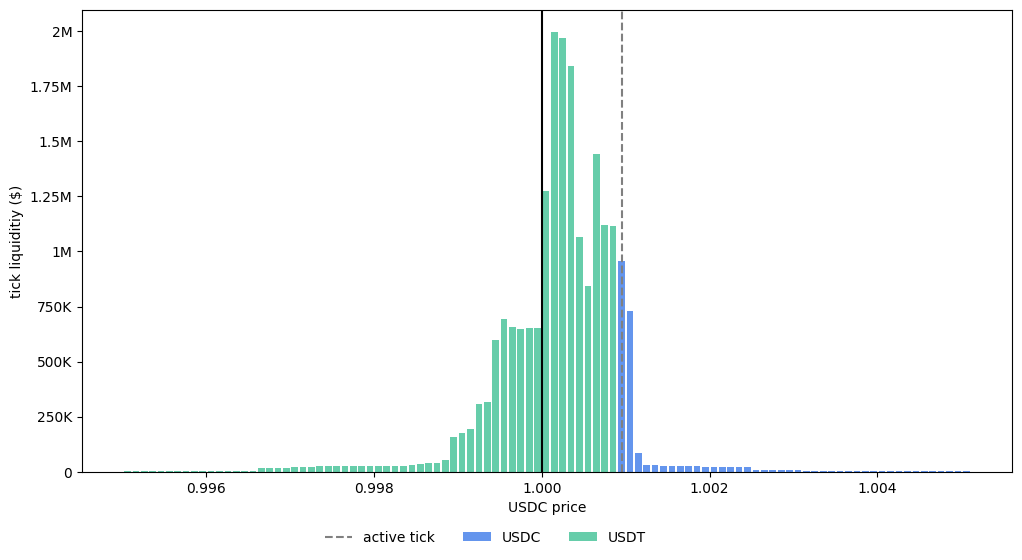

In [7]:
hours = np.array(sorted(df["hour"].unique()))
fig, ax = plt.subplots(1,1, figsize = (12,6))
plot_liq(df, hours[-1], ax)
def human_format(x, pos=None):
    x = float(x)
    absx = abs(x)
    if absx >= 1_000_000:
        val = x / 1_000_000
        return f"{val:g}M" if val % 1 else f"{int(val)}M"
    if absx >= 1_000:
        val = x / 1_000
        return f"{val:g}K" if val % 1 else f"{int(val)}K"
    return f"{x:g}"
ax.yaxis.set_major_formatter(FuncFormatter(human_format))

plt.savefig('liquidity_cliff.png', dpi = 300, transparent = True, bbox_inches = 'tight')

# Asymmetric slippage as a function of swap size

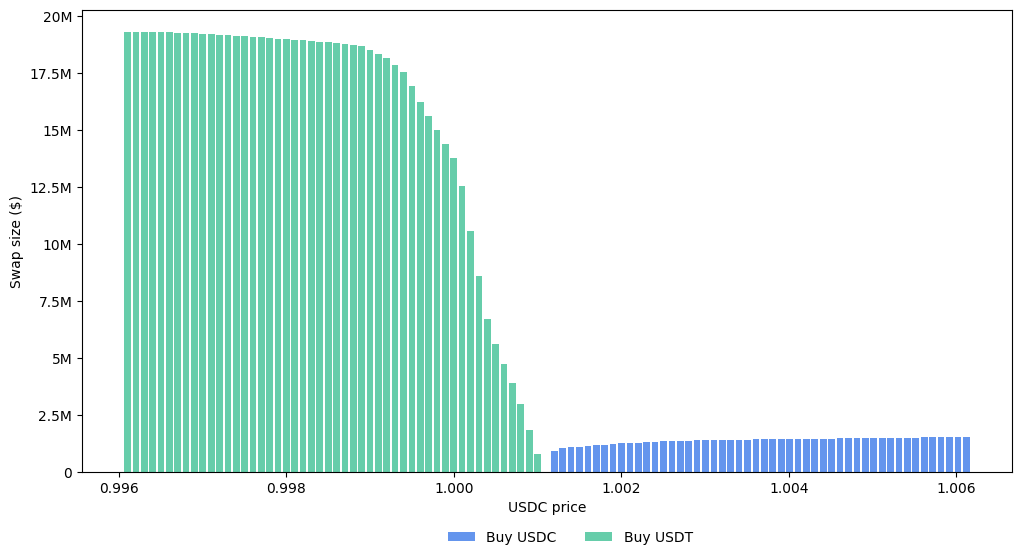

In [9]:
def tick_to_sqrtP(tick: int) -> float:
    return 1.0001 ** (tick / 2)

def build_L_per_tick_interval(snapshot: pd.DataFrame) -> pd.Series:
    """
    Returns a Series indexed by tickLower giving L for interval [tickLower, tickLower+1)
    If your intervals are wider than 1 tick, this expands them.
    """
    rows = []
    for tl, tu, L in snapshot[['tickLower','tickUpper','active_liquidity_L']].itertuples(index=False):
        # expand interval into 1-tick pieces
        for t in range(int(tl), int(tu)):
            rows.append((t, L))
    s = pd.Series(dict(rows))
    # if multiple entries per tick (shouldn't happen), sum them
    return s.groupby(level=0).sum().sort_index()

def swap_size_curve(dip: pd.DataFrame, k_max=50, fee=0.0, tick_step=1):
    """
    Returns a dataframe with required amount_in to move +/-k ticks from current poolTick.
    fee: pool fee as fraction (e.g. 0.0001, 0.0005, 0.003). Applied as amount_in / (1-fee).
    """
    # choose one timestamp snapshot (latest)
    ts = dip['timestamp'].max()
    snap = dip[dip['timestamp'] == ts].copy()

    cur_tick = int(snap['poolTick'].iloc[0])

    # liquidity per 1-tick interval
    L_by_tick = build_L_per_tick_interval(snap)

    # helper: get L for interval [t, t+1)
    def L_interval(t):
        return float(L_by_tick.loc[t])  # raises if missing

    out = []
    amt_up_token1 = 0.0   # token1 in (price up)
    amt_down_token0 = 0.0 # token0 in (price down)

    for k in range(1, k_max + 1):
        # ---- move UP by tick_step (repeat k times)
        t_up_from = cur_tick + (k-1)*tick_step
        t_up_to   = cur_tick + k*tick_step

        # sum per 1-tick substep if tick_step > 1
        delta1 = 0.0
        for t in range(t_up_from, t_up_to):
            L = L_interval(t)
            sa = tick_to_sqrtP(t)
            sb = tick_to_sqrtP(t+1)
            delta1 += L * (sb - sa)
        amt_up_token1 += delta1

        # ---- move DOWN by tick_step (repeat k times)
        # crossing intervals [cur_tick-1,cur_tick), [cur_tick-2,cur_tick-1), ...
        t_dn_from = cur_tick - (k-1)*tick_step
        t_dn_to   = cur_tick - k*tick_step

        delta0 = 0.0
        for t in range(t_dn_to, t_dn_from):  # e.g. t = cur_tick-k ... cur_tick-1
            L = L_interval(t)  # interval [t, t+1) is active when moving down across it
            sa = tick_to_sqrtP(t+1)  # start at higher tick boundary
            sb = tick_to_sqrtP(t)    # end at lower tick boundary
            delta0 += L * (1.0/sb - 1.0/sa)
        amt_down_token0 += delta0

        # apply fee to amount_in (simplified: divides by (1-fee))
        up_in  = amt_up_token1 / (1.0 - fee) if fee else amt_up_token1
        dn_in  = amt_down_token0 / (1.0 - fee) if fee else amt_down_token0

        out.append({
            "k_ticks": k*tick_step,
            "token1_in_to_move_up": up_in,
            "token0_in_to_move_down": dn_in,
            "tick_up": cur_tick + k*tick_step,
            "tick_down": cur_tick - k*tick_step,
        })

    return pd.DataFrame(out), cur_tick, ts

# ---- run + plot
curve, cur_tick, ts = swap_size_curve(dfp, k_max=50, fee=0.0, tick_step=1)

fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.bar(1.0001 ** curve["tick_up"], curve["token1_in_to_move_up"] / 1e6, width = 0.0001*0.8, color = 'cornflowerblue', label="Buy USDC")
ax.bar(1.0001 ** curve["tick_down"], curve["token0_in_to_move_down"] / 1e6, width = 0.0001*0.8,color = 'mediumaquamarine', label="Buy USDT")
# ax.xaxis.set_major_formatter(FuncFormatter(human_format))
ax.yaxis.set_major_formatter(FuncFormatter(human_format))
# ax.ticklabel_format(style='plain', useOffset=False)
ax.set_xlabel("USDC price")
ax.set_ylabel("Swap size ($)")
ax.legend(ncols = 2, frameon = False, bbox_to_anchor = (.67, -0.1))
plt.savefig('./swap_size_impact.png', dpi = 300, transparent = True, bbox_inches = 'tight');

# Plot tick liquidity curve

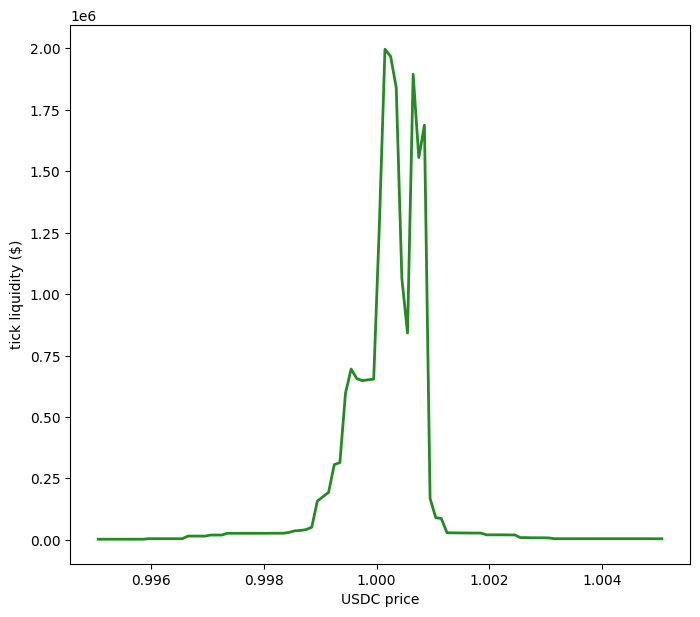

In [10]:
fig, ax = plt.subplots(1,1,figsize=(8,7))
fig.patch.set_alpha(0)
ax.set_facecolor((0, 0, 0, 0))
plotdf = df[df['hour'] == dt.datetime(2026,1,27,4, tzinfo= dt.timezone.utc)]
plt.plot(plotdf['priceMid'].values, plotdf['usd_total'].values, lw = 2, color = "forestgreen")
plt.xlabel('USDC price')
plt.ylabel('tick liquidity ($)')
plt.savefig('uniswap_liquidity_2026-01-27.png', dpi = 300, bbox_inches = 'tight', transparent=True)

# Animate hourly liqudity curve

In [123]:
# --- figure ---
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=200)
fig.subplots_adjust(bottom=0.18)
fig.patch.set_alpha(0)          # transparent figure background
ax.set_facecolor("none")        # transparent axes background

stop = 400

df_ = df[df["hour"].between(
    dt.datetime(2025, 10, 9, 0, tzinfo=dt.timezone.utc),
    dt.datetime(2025, 10, 9, 0, tzinfo=dt.timezone.utc) + dt.timedelta(hours=stop-1)
)]
x_min, x_max = df_["priceMid"].min(), df_["priceMid"].max()
y_max = (df_[["usd_token0", "usd_token1"]].sum(axis=1)).max()

# give a little padding
x_pad = 0.002 if np.isfinite(x_min) else 0.0
ax_xmin, ax_xmax = x_min - x_pad, x_max + x_pad
ax_ymin, ax_ymax = 0.0, 1.05 * y_max if np.isfinite(y_max) else 1.0


def _render_frame(k):
    ax.clear()
    ax.set_facecolor("none")

    hour = dt.datetime(2025, 10, 9, 0, tzinfo=dt.timezone.utc) + dt.timedelta(hours=k)
    df_day = df[df["hour"] == hour].sort_values(by="priceMid")

    if df_day.empty:
        # still render a blank frame with consistent axes
        ax.set_xlim(ax_xmin, ax_xmax)
        ax.set_ylim(ax_ymin, ax_ymax)
        ax.set_xlabel("USDC price")
        ax.set_ylabel("tick liquidity ($)")
        ax.set_title(f"{hour.isoformat()} (no data)")
        return

    x = df_day["priceMid"].to_numpy()

    # robust bar width (avoid errors when only 1 tick)
    if len(x) >= 2:
        w = 0.8 * np.min(np.diff(x))
    else:
        w = 0.0001  # fallback width

    ax.bar(x, df_day["usd_token0"].to_numpy(), width=w, label="USDC", color="cornflowerblue")
    ax.bar(x, df_day["usd_token1"].to_numpy(), width=w, label="USDT", color="mediumaquamarine")

    ax.axvline(1.0, color="black", linewidth=1)

    active = df_day.loc[df_day["usd_token0"] > 0, "priceMid"]
    if not active.empty:
        ax.axvline(active.iloc[0], color="grey", linestyle="--", label="active tick")

    ax.set_xlim(ax_xmin, ax_xmax)
    ax.set_ylim(ax_ymin, ax_ymax)

    ax.set_xlabel("USDC price")
    ax.set_ylabel("tick liquidity ($)")
    ax.set_title(hour.isoformat())

    ax.legend(frameon=False, bbox_to_anchor=(0.65, -0.1), ncols=3)


def frame_images():
    for k in range(stop):
        _render_frame(k)

        # IMPORTANT: draw AFTER plotting, then capture buffer
        fig.canvas.draw()
        rgba = np.asarray(fig.canvas.buffer_rgba())  # (H, W, 4)
        img = Image.fromarray(rgba, mode="RGBA")

        # Convert to palette GIF while keeping transparency:
        pal = img.convert("P", palette=Image.Palette.ADAPTIVE)
        transparent_index = pal.getpixel((0, 0))  # assumes background is uniform/transparent
        pal.info["transparency"] = transparent_index
        pal.info["disposal"] = 2  # restore to background between frames

        yield pal


# --- save GIF ---
it = frame_images()
first = next(it)
first.save(
    "liq_curve.gif",
    save_all=True,
    append_images=it,
    duration= 60,
    loop=0,
    optimize=True,        
    disposal=2,
    transparency=first.info.get("transparency", 0),
)

plt.close(fig)